In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn import preprocessing
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date
import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys


def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()

200


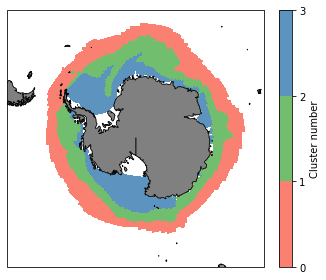

In [3]:
# Make a map to check what clusters are
year = 2015
filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
n_clusters = 3
filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_new_12345_'+str(year)+'.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']

day = 200
print(day)

n_days, n_lat, n_lon = ds['k'].shape

# Plot this on a map        
fontprops = fm.FontProperties(size=18)
plt.figure()
clevs=np.arange(0,4,1)

coord_lims = [-180, 180, -50, -90]
# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# define the bins and normalize
bounds = np.linspace(0, 3, 4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, ds['k'][day,:,:],
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
            shading='auto')
#plt.title(str(n_clusters)+" clusters")

cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 
savepath = '/home/566/nd0349/notebooks/'
plt.tight_layout()
#plt.savefig(savepath+'kmeans_map_day_200_'+str(year)+'.png', dpi = 300) 


In [3]:
ds

<xarray.Dataset>
Dimensions:      (time: 365, nj: 300, ni: 360)
Coordinates:
    LON          (nj, ni) float32 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
    LAT          (nj, ni) float32 -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
  * time         (time) object '2018-01-01' '2018-01-02' ... '2018-12-31'
Dimensions without coordinates: nj, ni
Data variables:
    k            (time, nj, ni) float64 ...
    aice         (time, nj, ni) float64 ...
    hi           (time, nj, ni) float64 ...
    hs           (time, nj, ni) float64 ...
    fsdrad       (time, nj, ni) float64 ...
    iage         (time, nj, ni) float64 ...
    alvl         (time, nj, ni) float64 ...
    wave_sig_ht  (time, nj, ni) float64 ...
    HTE          (nj, ni) float32 ...
    HTN          (nj, ni) float32 ...
    tarea        (nj, ni) float32 ...
    tmask        (nj, ni) float32 ...
Attributes:
    creation_date:  2023-04-07
    conventions:    
    title:          k-means clusters for CICE-WIM standalone 1-degree data
    source:         , 
    comment:        
    author:         Noah Day
    email:          noah.day@adelaide.edu.au

In [4]:
# Calculate MIZ width

miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise arrays
miz_width_array = np.empty((n_days,n_lon))
effective_miz_width_array = np.empty((n_days,n_lon))
sic_width_array = np.empty((n_days,n_lon))

miz_upper_boundary = np.empty((n_days,n_lon))
miz_lower_boundary = np.empty((n_days,n_lon))

interior_swh = np.empty((n_days,n_lon))
exterior_swh = np.empty((n_days,n_lon))

exterior_vatm = np.empty((n_days,n_lon))


day_vec = range(0,n_days, 90)


mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()


# Circumpolar for each day
for day_idx, filename in enumerate(onlyfiles):
    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    ds_day = xr.open_dataset(filename)

    for lon_idx in range(0,n_lon):
        # MIZ width
        miz_idx = ds['k'][day_idx,:,lon_idx].data == miz_cluster
#        locs = [i for i, x in enumerate(np.diff(miz_idx)) if x]
#        if len(locs) >= 2:
#            miz_idx[0:locs[-2]] = False
        sic_idx = ds['aice'][day_idx,:,lon_idx].data > 0.15
        miz_idx = miz_idx*sic_idx
        sic_1580_idx = np.logical_and(sic_idx,ds['aice'][day_idx,:,lon_idx].data < 0.8)
        if not any(miz_idx):
            # If there are no MIZ cells then set distance to 0
            miz_width_array[day_idx,lon_idx] = 0
            effective_miz_width_array[day_idx,lon_idx] = 0
            
            exterior_swh[day_idx,lon_idx] = LT[0,lon_idx]
            interior_swh[day_idx,lon_idx] = LT[0,lon_idx]
            
            miz_upper_boundary[day_idx,lon_idx] = ds['wave_sig_ht'][day_idx, 0,lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = ds['wave_sig_ht'][day_idx, 0,lon_idx]
            exterior_vatm[day_idx,lon_idx] = ds_day['vatm'][0, 0,lon_idx]
        else:
            miz_width_array[day_idx,lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
            effective_miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).sum()
            
            locs = np.asarray(miz_idx).nonzero()
            miz_upper_boundary[day_idx,lon_idx] = LT[locs[0][-1],lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = LT[locs[0][0],lon_idx]
            
            exterior_swh[day_idx,lon_idx] = ds['wave_sig_ht'][day_idx, locs[0][-1],lon_idx]
            interior_swh[day_idx,lon_idx] = ds['wave_sig_ht'][day_idx, locs[0][0],lon_idx]
            exterior_vatm[day_idx,lon_idx] = ds_day['vatm'][0, locs[0][0],lon_idx]
            
        if not any(sic_1580_idx):
            sic_width_array[day_idx,lon_idx] = 0
        else:
            sic_width_array[day_idx,lon_idx] = ds['HTE'][sic_1580_idx,lon_idx].data.sum()
print('Done!')

plot_exterior = exterior_swh.reshape(-1)
plot_interior = interior_swh.reshape(-1)


data = {
    'exterior' : plot_exterior[plot_exterior>0],
    'interior' : plot_interior[plot_exterior>0],
}

#pd.DataFrame(data).to_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_4_clusters.csv')

Progress: [####################] 100% 
Done!


In [15]:
onlyfiles[0:365:30]

['/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-01.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-31.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-03-02.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-04-01.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-05-01.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-05-31.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-06-30.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-07-30.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-08-29.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-09-28.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-10-28.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-11-27.nc',
 '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-12-27.nc']

In [4]:
import seaborn as sns

In [39]:
df_plot['miz_upper_boundary']
miz_upper_boundary.mean(1).shape
miz_upper_boundary.mean(1)

miz_upper_boundary.mean(1)[miz_upper_boundary.mean(1)>0]

array([2.11466585e-310, 2.04722121e-310, 1.92908230e-310, 1.88336376e-310,
       2.14478200e-310, 2.18887380e-310, 1.91829843e-310, 1.89385519e-310,
       2.03276712e-310, 1.82475565e-310, 1.84097171e-310, 2.13722414e-310,
       2.25785396e-310, 1.95221993e-310, 2.09900953e-310, 1.99072261e-310,
       1.78991204e-310, 2.02995222e-310, 2.04867226e-310, 2.15560183e-310,
       1.72815408e-310, 1.34234989e+274, 8.03789187e+001, 5.75817793e+001,
       8.24967174e+001, 4.32896298e+001, 7.56923610e+001, 4.76150335e+001,
       9.59015218e+001, 4.90655222e+001, 6.64674900e+001, 4.51947151e+001,
       9.91544557e+001, 4.53559184e+001, 9.34954123e+001, 6.68780357e+001,
       1.01408219e+002, 6.37589013e+001, 9.46539556e+001, 5.34413525e+001,
       5.89834732e+001, 4.95047844e+001, 9.03726078e+001, 2.93025565e+001,
       6.03869699e+001, 5.17239300e+001, 6.60617435e+001, 6.99389604e+001,
       8.62062879e+001, 1.45838896e+274, 1.77793465e+005, 1.51949980e+005,
       1.19707496e+005, 9

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


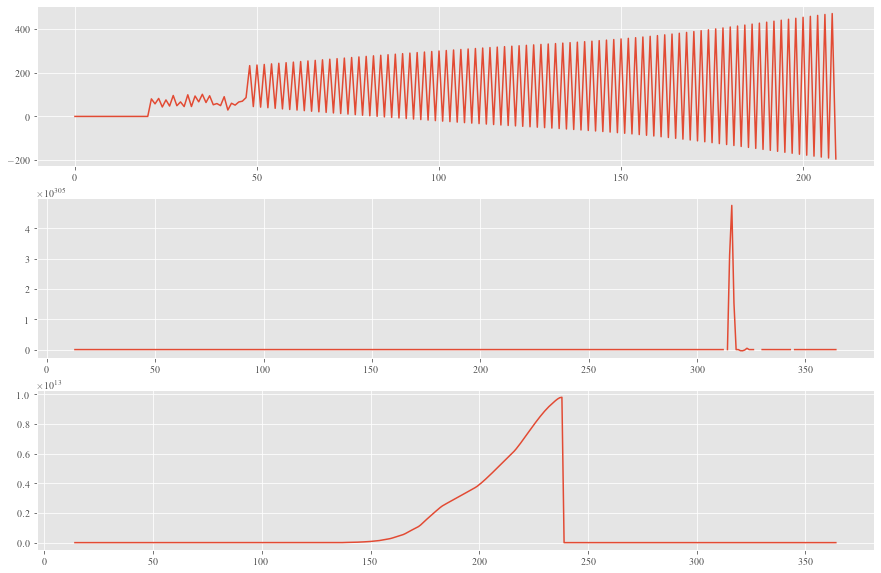

In [48]:
# Time series of change in exterior boundary and wind direction
df_plot = pd.DataFrame({'date': pd.date_range(start="2019-01-01",end="2019-12-31"),
                        'miz_upper_boundary': miz_upper_boundary.mean(),
                        'miz_lower_boundary': miz_upper_boundary.mean(),
                        'exterior_vatm': exterior_vatm.mean(),
                       })

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)

axes[0].plot(miz_upper_boundary.mean(1))
axes[1].plot(miz_lower_boundary.mean(1))
axes[2].plot(exterior_vatm.mean(1))
#sns.lineplot(ax=axes[0], x="date", y="exterior_vatm",
#             data=df_plot, errorbar=None)


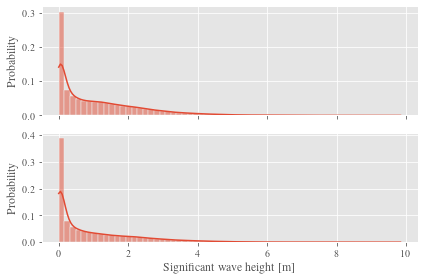

In [22]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 61


plot_data = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_4_clusters.csv')

#sns.histplot(data=plot_wave_pen[idx]/1000, kde=True, bins=n_bins)
fig, axs = plt.subplots(2,1,sharey=False, tight_layout=True, sharex=True)
sns.histplot(data=plot_data['exterior'], kde=True, bins=n_bins, ax=axs[0], stat='probability')

sns.histplot(data=plot_data['interior'], kde=True, bins=n_bins, ax=axs[1], stat='probability')
#axs[0].set_title('SWH $= 2\pm 0.2$ m, $\mu = %.2f$, $\sigma=%.2f$' %(np.mean(data['2']/1000), np.std(data['2']/1000)), fontsize=12)


plt.xlabel("Significant wave height [m]")
#plt.ylabel("Count")
# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'SWH_difference_4_clusters.png', dpi = 300)
plt.show()

#print(np.mean(plot_wave_pen[idx]/1000))
#print(np.std(plot_wave_pen[idx]/1000))





In [3]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.transforms as mtransforms

In [ ]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 21


# Preparation for maps ---------
filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-08-25.nc'
ds = xr.open_dataset(filename)
tmask = ds['tmask'][:,:]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,5,1)
year = 2019
coord_lims = [-180, 180, -50, -90]
# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0), 'purple'])
# define the bins and normalize
bounds = np.linspace(0, 4, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# Make the map
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)
# --------


fig, axs = plt.subplot_mosaic([['a)','b)', 'c)']],#,['d)','e)','f)']],
#                              nrows=2,ncols=3,#
                              subplot_kw={'projection': ccrs.SouthPolarStereo()},
                              figsize=(12,4.5))


plt.rcParams["font.family"] = "serif"
n_clusters = 2
for label, ax in axs.items():
    # Plot a map for the first 3
    if n_clusters < 5:
        readfilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cs = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:], plot_data,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    norm=norm,
                    shading='auto')

        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
        ax.set_extent(coord_lims, ccrs.PlateCarree())
        
        # region for the map inset
        insetBox = [-17.5,12,-11,17]

        # setup inset map and add layers
        ax_inset = fig.add_axes([0.45, 0.5, 0.6, 0.5],projection=ccrs.PlateCarree())
        ax_inset = cee.addLayer(waLandsat.clip(senegal),visParams=lsVis,region=insetBox,dims=2500,ax=ax_inset)
        ax_inset = cee.addLayer(adminImg,region=insetBox,ax=ax_inset)

        # Add coastlines
        ax.add_feature(land_50m)
        ax.coastlines()

    else:
        plot_data_2 = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_'+str(n_clusters-3)+'_clusters.csv')
        sns.histplot(data=plot_data_2['exterior'], kde=False, bins=n_bins, ax=ax, stat='probability',alpha=0.5,color='#619CFF')
        sns.histplot(data=plot_data_2['interior'], kde=False, bins=n_bins, ax=ax, stat='probability',color='#F8766D')
#        fig.legend(labels=['Incident','Interior boundary'])
#        plt.xlabel("Significant wave height [m]")
        
    n_clusters = n_clusters + 1
    

        

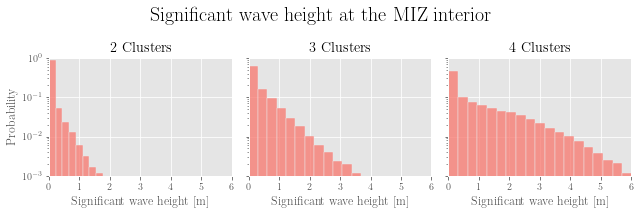

In [6]:
import seaborn as sns
fig, axs = plt.subplots(1,3,sharey=True, tight_layout=True, sharex=True,figsize=(9,3))
#rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'serif','serif':['Helvet']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 31


plot_data_2 = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_2_clusters.csv')
#sns.histplot(data=plot_data_2['exterior'], kde=False, bins=n_bins, ax=axs[0], stat='probability',alpha=0.5,color='#619CFF')
cdf2 = sns.histplot(data=plot_data_2['interior'], kde=False, bins=n_bins, ax=axs[0], stat='probability',color='#F8766D')
axs[0].set_title("2 Clusters")
axs[0].set_xlabel("Significant wave height [m]")

plot_data_3 = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_3_clusters.csv')
#sns.histplot(data=plot_data_3['exterior'], kde=False, bins=n_bins, ax=axs[1], stat='probability',alpha=0.5,color='#619CFF')
cdf3 = sns.histplot(data=plot_data_3['interior'], kde=False, bins=n_bins, ax=axs[1], stat='probability',color='#F8766D')
axs[1].set_xlabel("Significant wave height [m]")
axs[1].set_title("3 Clusters")

plot_data_4 = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_4_clusters.csv')
#sns.histplot(data=plot_data_4['exterior'], kde=False, bins=n_bins, ax=axs[2], stat='probability',alpha=0.5,color='#619CFF')
cdf4 = sns.histplot(data=plot_data_4['interior'], kde=False, bins=n_bins, ax=axs[2], stat='probability',color='#F8766D')
axs[2].set_title("4 Clusters")

#axs[2].legend(labels=['Incoming','Outgoing'])
axs[2].set_yscale('log')

fig.suptitle('Significant wave height at the MIZ interior',fontsize=20)
plt.xlabel("Significant wave height [m]")
plt.xlim((0.0,6))
plt.ylim((0.001,1))
#plt.ylabel("Count")
# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'cluster_number.png', dpi = 1000)
plt.show()


In [9]:
# Exceedence probability 
print(((plot_data_2['interior'] > 1).sum())/len(plot_data_2['interior']))
print(((plot_data_3['interior'] > 1).sum())/len(plot_data_3['interior']))
print(((plot_data_4['interior'] > 1).sum())/len(plot_data_4['interior']))

# Mean of each
print('Means')
print(plot_data_2['interior'].mean())
print(plot_data_3['interior'].mean())
print(plot_data_4['interior'].mean())

0.011682725550237515
0.11408455930096655
0.34620699066887295
Means
0.08228204227017243
0.39216120100494123
0.9503417676828732


/jobfs/86639206.gadi-pbs/ipykernel_3883066/3813077948.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=plot_data_4['interior']).get_lines()[0].get_data()


(array([-0.40730131, -0.35380274, -0.30030417, -0.2468056 , -0.19330704,
        -0.13980847, -0.0863099 , -0.03281133,  0.02068724,  0.07418581,
         0.12768438,  0.18118295,  0.23468152,  0.28818008,  0.34167865,
         0.39517722,  0.44867579,  0.50217436,  0.55567293,  0.6091715 ,
         0.66267007,  0.71616864,  0.7696672 ,  0.82316577,  0.87666434,
         0.93016291,  0.98366148,  1.03716005,  1.09065862,  1.14415719,
         1.19765576,  1.25115432,  1.30465289,  1.35815146,  1.41165003,
         1.4651486 ,  1.51864717,  1.57214574,  1.62564431,  1.67914288,
         1.73264144,  1.78614001,  1.83963858,  1.89313715,  1.94663572,
         2.00013429,  2.05363286,  2.10713143,  2.16063   ,  2.21412856,
         2.26762713,  2.3211257 ,  2.37462427,  2.42812284,  2.48162141,
         2.53511998,  2.58861855,  2.64211712,  2.69561568,  2.74911425,
         2.80261282,  2.85611139,  2.90960996,  2.96310853,  3.0166071 ,
         3.07010567,  3.12360424,  3.1771028 ,  3.2

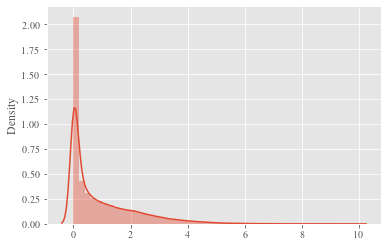

In [31]:
#plt.plot(cdf2.get_xdata(), cdf2.get_ydata())
sns.distplot(x=plot_data_4['interior']).get_lines()[0].get_data()

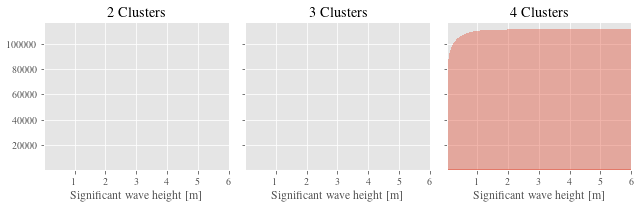

In [ ]:
# CDF



fig, axs = plt.subplots(1,3,sharey=True, tight_layout=True, sharex=True,figsize=(9,3))
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 31


plot_data_2 = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_2_clusters.csv')
#sns.histplot(data=plot_data_2['exterior'], kde=False, bins=n_bins, ax=axs[0], stat='probability',alpha=0.5,color='#619CFF')
sns.histplot(data=plot_data_2['interior'], kde=False, bins=n_bins, ax=axs[0], stat='probability',color='#F8766D')
axs[0].set_title("2 Clusters")
axs[0].set_xlabel("Significant wave height [m]")

plot_data_3 = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_3_clusters.csv')
#sns.histplot(data=plot_data_3['exterior'], kde=False, bins=n_bins, ax=axs[1], stat='probability',alpha=0.5,color='#619CFF')
sns.histplot(data=plot_data_3['interior'], kde=False, bins=n_bins, ax=axs[1], stat='probability',color='#F8766D')
axs[1].set_xlabel("Significant wave height [m]")
axs[1].set_title("3 Clusters")

plot_data_4 = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_4_clusters.csv')
#sns.histplot(data=plot_data_4['exterior'], kde=False, bins=n_bins, ax=axs[2], stat='probability',alpha=0.5,color='#619CFF')
sns.histplot(data=plot_data_4['interior'], kde=False, bins=n_bins, ax=axs[2], stat='probability',color='#F8766D')
axs[2].set_title("4 Clusters")

#axs[2].legend(labels=['Incoming','Outgoing'])
axs[2].set_yscale('log')

plt.xlabel("Significant wave height [m]")
plt.xlim((0.01,6))
#plt.ylabel("Count")
# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'cluster_number.png', dpi = 1000)
plt.show()


<AxesSubplot:>

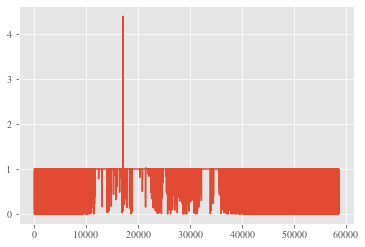

In [32]:
sns.lineplot(data=plot_data_4['interior']/plot_data_4['exterior'])

In [15]:
filename="/g/data/ia40/sea-ice-classification/mizWidth_"+str(year)+".nc"
d_vars = {"effective" : (['time','nj'],effective_miz_width_array,
                              {'long_name' :"Effective width",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "sic" : (['time','nj'],sic_width_array,
                              {'long_name' :"Sea ice concentration width [0.15, 0.8]",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "absolute" : (['time','nj'],miz_width_array,
                          {'long_name':"Absolute width",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "upper_location" : (['time','nj'],miz_upper_boundary,
                          {'long_name':"Northern MIZ boundary",
                           'units'    :"m",
                           '_FillValue':-2e8}),
         "lower_location" : (['time','nj'],miz_lower_boundary,
                              {'long_name' :"Southern MIZ boundary",
                               'units'     :"degrees",
                               '_FillValue':-2e8})}
          
coords = {"LON"  : (["nj"],LN[1,:].data,{'units':'degrees_east'}),
          "time" : (["time"],range(1,366))}
attrs = {'creation_date': "2023-05-12",#datetime.now().strftime('%Y-%m-%d %H'),
         'conventions'  : "",
         'title'        : "MIZ width for CICE-WIM standalone 1-degree data",
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
write_job = nc_out.to_netcdf(filename,unlimited_dims=['time'],compute=False)#,encoding={'glbrad':enc_dict})


In [15]:
miz_lower_boundary.shape

effective_miz_width_array.shape


effective_miz_width_array.shape
x_dates

#miz_width_array[:,:].mean(axis=1)/1000
#x_dates[day_vec]
x_dates
tmp = effective_miz_width_array[:,:].mean(axis=1)/1000
tmp[150]

374.1221350639595

[46, 135, 258, 349]


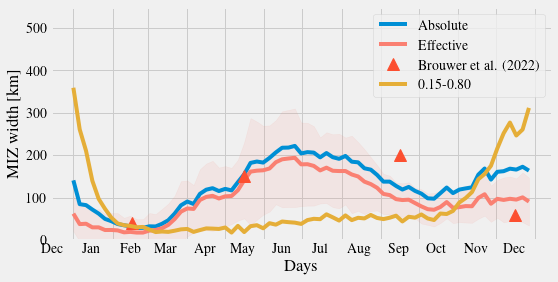

In [7]:
filename = "/g/data/ia40/sea-ice-classification/mizWidth_"+str(year)+".nc"
ds = xr.open_dataset(filename)
effective_miz_width_array = ds['effective']
miz_width_array = ds['absolute']
sic_width_array = ds['sic']
day_vec = range(0,n_days,5)


Cmap = np.asarray([[0.9805, 0.5000, 0.4453], [0.4416, 0.7490, 0.4322], [0.3639, 0.5755, 0.748]])
    
    
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#x_dates = np.array(unique_dates[day_vec], dtype=np.datetime64)
x_dates = range(0,365)
x_dates = day_vec
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))

monthly_locator = mdates.MonthLocator()
#ax.xaxis.set_major_locator(half_year_locator)
#ax.xaxis.set_minor_locator(monthly_locator)
#ax.xaxis.set_major_formatter(month_year_formatter)
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))#(1,2,3,4,5,6,7,8,9,10,11,12)))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

brouwer_dates = [31+15,31+28+31+30+15,31+28+31+30+31+30+31+31+15,31+28+31+30+31+30+31+31+30+31+30+15]
brouwer_linear_centre = [36.187, 143.457, 192.569, 60.743]
brouwer_linear_lower = [20.679, 100.808, 125.363, 33.603]
brouwer_linear_upper = [60.743, 186.107, 275.283, 148.627]

print(brouwer_dates)

print(mdates.MonthLocator(bymonthday=15))

#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

line_deviation = 1 * (effective_miz_width_array[day_vec,:].std(axis=1)/1000)
mean = effective_miz_width_array[day_vec,:].mean(axis=1)/1000
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_width_array[day_vec,:].mean(axis=1)/1000, label = "Absolute")
plt.plot(x_dates, mean, label = "Effective", color=Cmap[0,:])
plt.plot(brouwer_dates,[40,150,200,60], '^', markersize=12, label = "Brouwer et al. (2022)")
plt.plot(x_dates, sic_width_array[day_vec,:].mean(axis=1)/1000, label = "0.15-0.80")


plt.fill_between(x_dates, lower, upper, color=Cmap[0,:], alpha=.1)


#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("MIZ width [km]")
plt.legend()
ax.set_ylim([0, 550])
plt.show()

fig.autofmt_xdate()
#fig.savefig(savepath+'miz_width_'+str(year)+'.png', dpi = 300) 


84
154
264
354
354
84
Amundsen Belling
154
219
Weddell
219
264


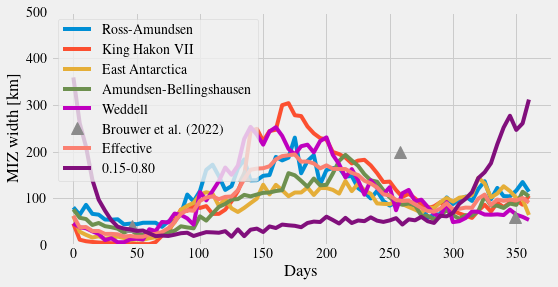

In [50]:
filename = "/g/data/ia40/sea-ice-classification/mizWidth_"+str(year)+".nc"
ds = xr.open_dataset(filename)
effective_miz_width_array = ds['effective']
sic_width_array = ds['sic']
day_vec = range(0,n_days,5)

filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']


# MIZ Width sectors
x_dates = day_vec
# SECTORS
## Ross-Amundsen Sea
sector_min = 165
sector_max = 235
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
line_deviation = 1 * ((effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max]/1000).std(axis=1))
mean = effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)/1000
lower = (mean - line_deviation)
upper = (mean + line_deviation)


fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(x_dates, mean, label = "Ross-Amundsen")
#plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)


## King Hakon VII
sector_min = 345
sector_max = 75
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
line_deviation = 1 * ((effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max]/1000).std(axis=1))
mean = effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)/1000
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, mean, label = "King Hakon VII")
#plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)


## East Antarctica
sector_min = 75
sector_max = 165
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx[0]
line_deviation = 1 * ((effective_miz_width_array[day_vec,sector_idx.values]/1000).std(axis=1))
mean = (effective_miz_width_array[day_vec,sector_idx.values]/1000).mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, mean, label="East Antarctica")
#plt.fill_between(x_dates, lower, upper, color='y', alpha=.1)


## Amundsen Belling
print("Amundsen Belling")
sector_min = 235
sector_max = 300
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
line_deviation = 1 * ((effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max]/1000).std(axis=1))
mean = (effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max]/1000).mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, mean, label = "Amundsen-Bellingshausen")
#plt.fill_between(x_dates, lower, upper, color='g', alpha=.1)

## Weddell
print("Weddell")
sector_min = 300
sector_max = 345
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
line_deviation = 1 * ((effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max]/1000).std(axis=1))
mean = (effective_miz_width_array[day_vec,sector_idx_min:sector_idx_max]/1000).mean(axis=1)
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, mean, label = "Weddell", color='m')
#plt.fill_between(x_dates, lower, upper, color='m', alpha=.1)

# Brouwer 2022
brouwer_dates = [31+15,31+28+31+30+15,31+28+31+30+31+30+31+31+15,31+28+31+30+31+30+31+31+30+31+30+15]
plt.plot(brouwer_dates,[40,150,200,60], '^', markersize=12, label = "Brouwer et al. (2022)")
plt.plot(x_dates, effective_miz_width_array[day_vec,:].mean(axis=1)/1000, label = "Effective", color=Cmap[0,:])
plt.plot(x_dates, sic_width_array[day_vec,:].mean(axis=1)/1000, label = "0.15-0.80")
#plt.fill_between(x_dates, lower, upper, color=Cmap[0,:], alpha=.1)

plt.xlabel("Days")
plt.ylabel("MIZ width [km]")
plt.legend()
plt.ylim((0,500))
plt.show()

fig.autofmt_xdate()
savepath = '/home/566/nd0349/notebooks/'
fig.savefig(savepath+'miz_width_sector_'+str(year)+'.png', dpi = 300) 
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")

In [7]:
def get_sector_idx(sector_name, LN):
    '''
    Get an index for each sector from Hobbs et al.
    '''
    if sector_name == 'RA':
        # Ross-Amundsen
        sector_min = 165
        sector_max = 235
        a = abs(LN[1,:]-sector_min)
        sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
        a = abs(LN[1,:]-sector_max)
        sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
        sector_idx = range(sector_idx_min,sector_idx_max)
    elif sector_name == 'KH':
        # King Hakon
        sector_min = 345
        sector_max = 75
        a = abs(LN[1,:]-sector_min)
        sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
        a = abs(LN[1,:]-sector_max)
        sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
        sector_idx = range(sector_idx_min,sector_idx_max)
    elif sector_name == 'EA':
        # East Antarctica
        sector_min = 75
        sector_max = 165
        a = abs(LN[1,:]-sector_min)
        sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
        a = abs(LN[1,:]-sector_max)
        sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
        print(sector_idx_min)
        print(sector_idx_max)
        sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
        sector_idx = sector_idx.values
    elif sector_name == 'AB':
        # Amundsen Bellingshaushen
        sector_min = 235
        sector_max = 300
        a = abs(LN[1,:]-sector_min)
        sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
        a = abs(LN[1,:]-sector_max)
        sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
        sector_idx = range(sector_idx_min,sector_idx_max)
    elif sector_name == 'W':
        # Weddell Sea
        sector_min = 300
        sector_max = 345
        a = abs(LN[1,:]-sector_min)
        sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
        a = abs(LN[1,:]-sector_max)
        sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
        sector_idx = range(sector_idx_min,sector_idx_max)
    return sector_idx
import seaborn as sns

354
84
354
84


Text(0.5, 1.0, 'Weddell')

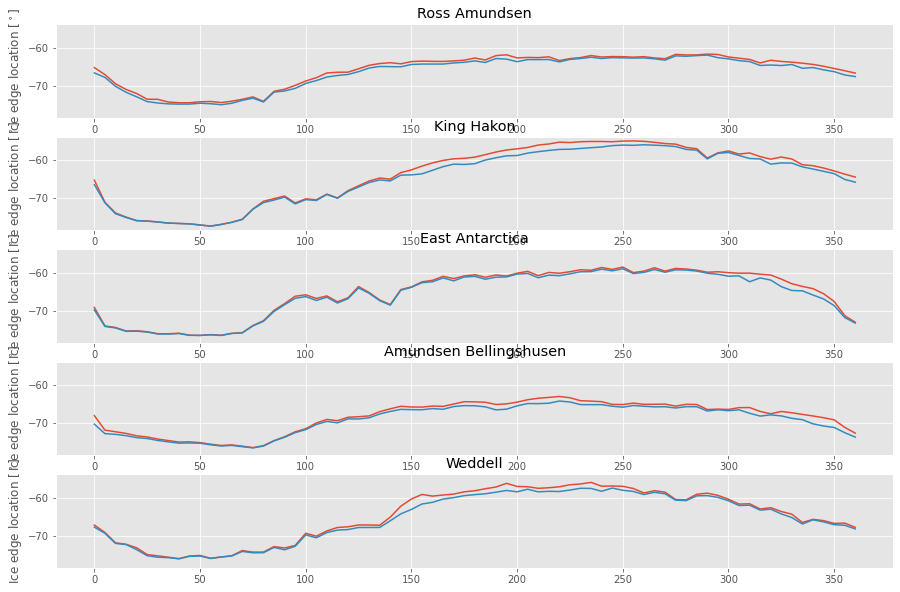

In [14]:
# Time series plot
filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']


day_vec = range(0,365,5)
x_dates = day_vec


plt.style.use("ggplot")
#sns.set_context("talk")
# set figure size
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharey=True)  

 
#data = df_plot

#fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot(x_dates, mean, label = "Ross-Amundsen")
sns.lineplot(ax=axes[0], x=x_dates, y=upper_location[day_vec,get_sector_idx("RA", LN)].mean(axis=1), errorbar=None)
sns.lineplot(ax=axes[0], x=x_dates, y=lower_location[day_vec,get_sector_idx("RA", LN)].mean(axis=1), errorbar=None)
axes[0].set(ylabel='Ice edge location [$^\circ$]')
axes[0].set_title('Ross Amundsen')

sns.lineplot(ax=axes[1], x=x_dates, y=upper_location[day_vec,get_sector_idx("KH", LN)].mean(axis=1), errorbar=None)
sns.lineplot(ax=axes[1], x=x_dates, y=lower_location[day_vec,get_sector_idx("KH", LN)].mean(axis=1), errorbar=None)
axes[1].set(ylabel='Ice edge location [$^\circ$]')
axes[1].set_title('King Hakon')

sns.lineplot(ax=axes[2], x=x_dates, y=upper_location[day_vec,get_sector_idx("EA", LN)].mean(axis=1), errorbar=None)
sns.lineplot(ax=axes[2], x=x_dates, y=lower_location[day_vec,get_sector_idx("EA", LN)].mean(axis=1), errorbar=None)
axes[2].set(ylabel='Ice edge location [$^\circ$]')
axes[2].set_title('East Antarctica')

sns.lineplot(ax=axes[3], x=x_dates, y=upper_location[day_vec,get_sector_idx("AB", LN)].mean(axis=1), errorbar=None)
sns.lineplot(ax=axes[3], x=x_dates, y=lower_location[day_vec,get_sector_idx("AB", LN)].mean(axis=1), errorbar=None)
axes[3].set(ylabel='Ice edge location [$^\circ$]')
axes[3].set_title('Amundsen Bellingshusen')

sns.lineplot(ax=axes[4], x=x_dates, y=upper_location[day_vec,get_sector_idx("W", LN)].mean(axis=1), errorbar=None)
sns.lineplot(ax=axes[4], x=x_dates, y=lower_location[day_vec,get_sector_idx("W", LN)].mean(axis=1), errorbar=None)
axes[4].set(ylabel='Ice edge location [$^\circ$]')
axes[4].set_title('Weddell')


In [2]:
# Upper and lower boundaries
year = 2019
filename = "/g/data/ia40/sea-ice-classification/mizWidth_"+str(year)+".nc"
ds = xr.open_dataset(filename)
upper_location = ds['upper_location']
lower_location = ds['lower_location']
day_vec = range(0,n_days,5)

filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']


# MIZ Width sectors
x_dates = day_vec
# SECTORS
## Ross-Amundsen Sea
sector_min = 165
sector_max = 235
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
mean = upper_location[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)


fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(x_dates, mean, label = "Ross-Amundsen")
#plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)


## King Hakon VII
sector_min = 345
sector_max = 75
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
mean = upper_location[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)

plt.plot(x_dates, mean, label = "King Hakon VII")
#plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)


## East Antarctica
sector_min = 75
sector_max = 165
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx[0]
#line_deviation = 1 * ((effective_miz_width_array[day_vec,sector_idx.values]/1000).std(axis=1))
mean = (upper_location[day_vec,sector_idx.values]).mean(axis=1)


plt.plot(x_dates, mean, label="East Antarctica")
#plt.fill_between(x_dates, lower, upper, color='y', alpha=.1)


## Amundsen Belling
print("Amundsen Belling")
sector_min = 235
sector_max = 300
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
mean = (upper_location[day_vec,sector_idx_min:sector_idx_max]).mean(axis=1)


plt.plot(x_dates, mean, label = "Amundsen-Bellingshausen")
#plt.fill_between(x_dates, lower, upper, color='g', alpha=.1)

## Weddell
print("Weddell")
sector_min = 300
sector_max = 345
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
mean = (upper_location[day_vec,sector_idx_min:sector_idx_max]).mean(axis=1)

plt.plot(x_dates, mean, label = "Weddell", color='m')
#plt.fill_between(x_dates, lower, upper, color='m', alpha=.1)


plt.xlabel("Days")
plt.ylabel("Upper boundary [$^\circ$]")
plt.legend()

plt.show()

fig.autofmt_xdate()
savepath = '/home/566/nd0349/notebooks/'
fig.savefig(savepath+'upper_location_sector_'+str(year)+'.png', dpi = 300) 
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")


NameError: name 'xr' is not defined

In [4]:
# Upper and lower boundaries

filename = "/g/data/ia40/sea-ice-classification/mizWidth_"+str(year)+".nc"
ds = xr.open_dataset(filename)
upper_location = ds['upper_location']
lower_location = ds['lower_location']
day_vec = range(0,n_days,5)

filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']


# MIZ Width sectors
x_dates = day_vec
# SECTORS
## Ross-Amundsen Sea
sector_min = 165
sector_max = 235
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
mean = lower_location[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)/1000


fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(x_dates, mean, label = "Ross-Amundsen")
#plt.fill_between(x_dates, lower, upper, color='b', alpha=.1)


## King Hakon VII
sector_min = 345
sector_max = 75
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
mean = lower_location[day_vec,sector_idx_min:sector_idx_max].mean(axis=1)/1000

plt.plot(x_dates, mean, label = "King Hakon VII")
#plt.fill_between(x_dates, lower, upper, color='r', alpha=.1)


## East Antarctica
sector_min = 75
sector_max = 165
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx[0]
#line_deviation = 1 * ((effective_miz_width_array[day_vec,sector_idx.values]/1000).std(axis=1))
mean = (lower_location[day_vec,sector_idx.values]/1000).mean(axis=1)


plt.plot(x_dates, mean, label="East Antarctica")
#plt.fill_between(x_dates, lower, upper, color='y', alpha=.1)


## Amundsen Belling
print("Amundsen Belling")
sector_min = 235
sector_max = 300
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
mean = (lower_location[day_vec,sector_idx_min:sector_idx_max]/1000).mean(axis=1)


plt.plot(x_dates, mean, label = "Amundsen-Bellingshausen")
#plt.fill_between(x_dates, lower, upper, color='g', alpha=.1)

## Weddell
print("Weddell")
sector_min = 300
sector_max = 345
a = abs(LN[1,:]-sector_min)
sector_idx_min, = np.unravel_index(a.argmin(),a.shape)
a = abs(LN[1,:]-sector_max)
sector_idx_max, = np.unravel_index(a.argmin(),a.shape)
print(sector_idx_min)
print(sector_idx_max)
#sector_idx = ((LN[1,:] > sector_min) & (LN[1,:] < sector_max))
#sector_idx = sector_idx
mean = (lower_location[day_vec,sector_idx_min:sector_idx_max]/1000).mean(axis=1)

plt.plot(x_dates, mean, label = "Weddell", color='m')
#plt.fill_between(x_dates, lower, upper, color='m', alpha=.1)


plt.xlabel("Days")
plt.ylabel("Lower boundary []")
plt.legend()

plt.show()

fig.autofmt_xdate()
savepath = '/home/566/nd0349/notebooks/'
fig.savefig(savepath+'lower_location_sector_'+str(year)+'.png', dpi = 300) 
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")

NameError: name 'n_days' is not defined

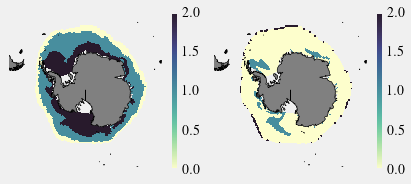

In [45]:
ds = xr.open_dataset('/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-01.nc')
LN = ds.TLON.values
LT = ds.TLAT.values
ds = xr.open_dataset('/g/data/ia40/sea-ice-classification/kmean_2019.nc')
k_plot = ds['k'][180,:,:]

plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, -50, -90]
counter = 1
ax = plt.subplot(1, 2, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, k_plot,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)

ds = xr.open_dataset('/g/data/ia40/sea-ice-classification/kmean_nofsd_2019.nc')
k_plot = ds['k'][180,:,:]
ax = plt.subplot(1, 2, 0+2, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, k_plot,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
#ax.add_artist(scalebar)
plt.savefig('/g/data/ia40/sea-ice-classification/'+'kmean.png', dpi = 300)   


In [ ]:
plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, -50, -90]

ax = plt.subplot(1, 2, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, k_means_array,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)

In [42]:
#ds['k'][180,:,:].shape
#ds['k'][180,0:50,:].data
#ds['LAT'].shape

#k_plot[10:50,1]
print(k_plot.shape)
print(LN.shape)
print(LT.shape)

(300, 360)
(300, 360)
(300, 360)


In [6]:
import seaborn as sns


In [2]:
# MIZ width over a few years

miz_width_2010 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2010.nc')
miz_width_2011 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2011.nc')
miz_width_2012 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2012.nc')
miz_width_2013 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2013.nc')
miz_width_2014 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2014.nc')
miz_width_2015 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2015.nc')
miz_width_2016 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2016.nc')
miz_width_2017 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2017.nc')
miz_width_2018 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2018.nc')
miz_width_2019 = xr.open_dataset('/g/data/ia40/sea-ice-classification/mizWidth_2019.nc')




In [35]:
# Create a dataframe
day_vec = range(0,365,5)
idx = day_vec
d = {'2010':miz_width_2010['effective'][idx,:].mean(axis=1)/1000,
     '2011':miz_width_2011['effective'][idx,:].mean(axis=1)/1000,
     '2012':miz_width_2012['effective'][idx,:].mean(axis=1)/1000,
     '2013':miz_width_2013['effective'][idx,:].mean(axis=1)/1000,
     '2014':miz_width_2014['effective'][idx,:].mean(axis=1)/1000,
     '2015':miz_width_2015['effective'][idx,:].mean(axis=1)/1000,
     '2016':miz_width_2016['effective'][idx,:].mean(axis=1)/1000,
     '2019': miz_width_2019['effective'][idx,:].mean(axis=1)/1000}
df = pd.DataFrame(data=d)

d = {'2010':miz_width_2010['absolute'][idx,:].mean(axis=1)/1000,
     '2011':miz_width_2011['absolute'][idx,:].mean(axis=1)/1000,
     '2012':miz_width_2012['absolute'][idx,:].mean(axis=1)/1000,
     '2013':miz_width_2013['absolute'][idx,:].mean(axis=1)/1000,
     '2014':miz_width_2014['absolute'][idx,:].mean(axis=1)/1000,
     '2015':miz_width_2015['absolute'][idx,:].mean(axis=1)/1000,
     '2016':miz_width_2016['absolute'][idx,:].mean(axis=1)/1000,
     '2019': miz_width_2019['absolute'][idx,:].mean(axis=1)/1000}
df_abs = pd.DataFrame(data=d)

<Figure size 432x288 with 0 Axes>

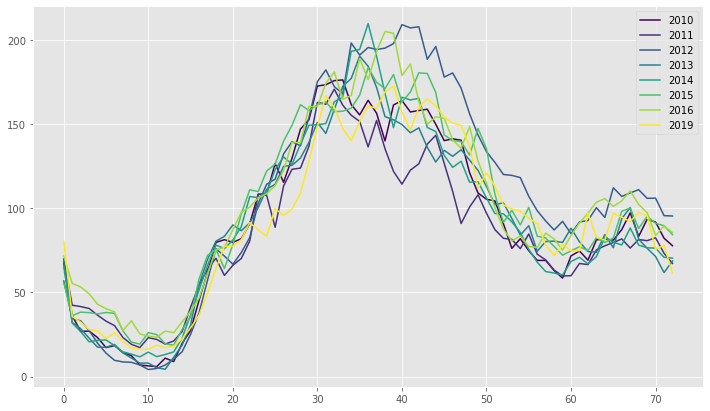

In [26]:
# Define your mappable for colorbar creation
import seaborn as sns
sm = plt.cm.ScalarMappable(cmap='viridis', 
                           norm=plt.Normalize(vmin=2010,
                                              vmax=2019))


#sm._A = []  
plt.style.use("ggplot")

plt.figure()

#ax = plt.subplot()
x_dates = np.linspace(0, 365,365)
df.plot(legend=True, colormap='viridis', figsize=(12,7));
#ax = sns.lineplot(x=x_dates[idx],y=df['2010'])

#cbar = plt.colorbar(sm);
# Change the numeric ticks into ones that match the x-axis
#cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


NameError: name 'ticker' is not defined

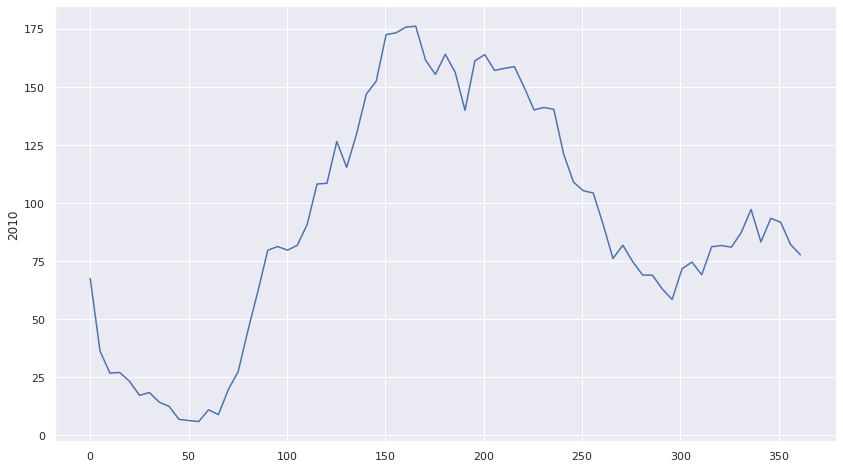

In [31]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})
idx = day_vec
x_dates = np.linspace(0, 365,365)

ax = sns.lineplot(x=x_dates[idx],y=df['2010'])# x ='YM', y = 'PM2.5',
#                  hue='Years', palette='viridis',
#                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('PM2.5 (µg/m3)')
plt.xlabel('Year-Month')
plt.show()

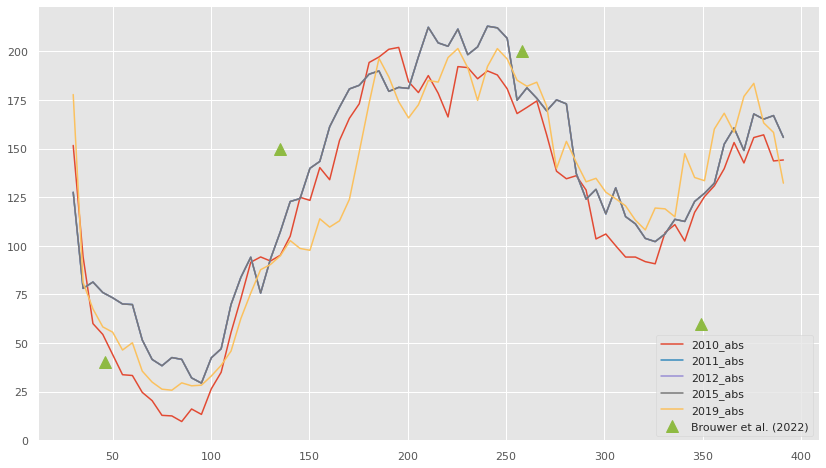

In [44]:
#idx = df['2010'].abs() < 1000
plt.style.use("ggplot")
idx = day_vec
x_dates = np.linspace(0, 365,365)+30

fig, ax = plt.subplots()
# ax.plot(x_dates[idx], df['2010'], label='2010')
# ax.plot(x_dates[idx], df['2015'], label='2015')
# ax.plot(x_dates[idx], df['2019'], label='2019')

ax.plot(x_dates[idx], df_abs['2010'], label='2010_abs')
ax.plot(x_dates[idx], df_abs['2015'], label='2011_abs')
ax.plot(x_dates[idx], df_abs['2015'], label='2012_abs')
ax.plot(x_dates[idx], df_abs['2015'], label='2015_abs')
ax.plot(x_dates[idx], df_abs['2019'], label='2019_abs')

brouwer_dates = [31+15,31+28+31+30+15,31+28+31+30+31+30+31+31+15,31+28+31+30+31+30+31+31+30+31+30+15]
plt.plot(brouwer_dates,[40,150,200,60], '^', markersize=12, label = "Brouwer et al. (2022)")
plt.legend()

In [27]:
day_vec = range(0,365,5)


## MIZ percentage of SIE

## MIZ percentage of SIE

In [ ]:
# Calculate MIZ width
year = 2018
filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
ds = xr.open_dataset(filename)

miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise arrays
SIE_MIZ = np.empty((n_days))
SIE_total = np.empty((n_days))


day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    SIE_MIZ[day_idx] = np.multiply(ds['tarea'][:,:].data, ds['k'][day_idx,:,:].data == miz_cluster).sum()
    SIE_total[day_idx] = np.multiply(ds['tarea'][:,:].data, ds['aice'][day_idx,:,:].data > 0.15).sum()
print('Done!')

In [100]:
SIE_MIZ

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,